<a href="https://colab.research.google.com/github/Mogarthron/Magazynier/blob/master/ZAM_PIANKI_DB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sqlalchemy import create_engine, Column, String, Integer, Numeric, text
from sqlalchemy.orm import declarative_base, sessionmaker
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from sqlalchemy import update, insert, delete

Base = declarative_base()

class ZAM_PIANKI(Base):
  __tablename__ = "ZAM_PIANKI"

  lp = Column("LP", Integer, autoincrement=True,  primary_key=True)

  tydzien = Column("TYDZIEN", Integer)
  kod = Column("KOD", String)
  model = Column("MODEL", String)
  nr_kompletacji = Column("NR_KOMPLETACJI", String(5))
  opis = Column("OPIS", String)
  ile_zam = Column("ILE_ZAMOWIONE", Numeric)
  znacznik_dostawcy = Column("ZNACZNIK_DOSTAWCY", String(2))
  galanteria = Column("GALANTERIA", String(1))
  siedziska_HR = Column("SIEDZISKA_HR", String(1))
  leniwa = Column("LENIWA", String(1))
  zam1 = Column("ZAM1", String(7))
  zam2 = Column("ZAM2", String(7))
  uwagi = Column("UWAGI", String)


  potw_dos1 = Column("POTW_DATA_DOS_1", String)
  potw_dos2 = Column("POTW_DATA_DOS_2", String)
  data_dos1 = Column("DATA_DOSTARCZENIA_1", String(10))
  data_dos2 = Column("DATA_DOSTARCZENIA_2", String(10))

  status_leniwa = Column("STATUS_LENIWA", String(30))
  status_leniwa_skoks = Column("STATUS_LENIWA_SKOSOWANIE", String(30))
  status_owaty = Column("STATUS_OWATY", String(30))
  nr_pz = Column("nr_PZ", String)
  nr_pw = Column("nr_PW", String)
  status_kompletacja = Column("STATUS_KOMPLETACJA", String(50))
  nr_samochodu = Column("nr_SAMOCHODU", String(50))

  def __init__(self, tydzien=None, model=None, kod=None, opis=None, ile_zam=None, znacznik_dostawcy=None, galanteria=None, siedziska_HR=None, leniwa=None, nr_kompletacji=None, zam1=None, zam2=None, uwagi=None):
    self.tydzien = tydzien
    self.kod = kod
    self.model = model
    self.nr_kompletacji = nr_kompletacji
    self.opis = opis
    self.ile_zam = ile_zam
    self.znacznik_dostawcy = znacznik_dostawcy
    self.galanteria = galanteria
    self.siedziska_HR = siedziska_HR
    self.leniwa = leniwa
    self.zam1 = zam1
    self.zam2 = zam2
    self.uwagi = uwagi

  def __repr__(self):
    return f"{self.tydzien}, {self.opis}"


def ZAM_PIANKI_update_date_dos_zam(nr_zam1=None, nr_zam2=None, potwierdzona_data_dos1=None, potwierdzona_data_dos2=None):
  if nr_zam1:
    stmt1 = (
        update(ZAM_PIANKI)
        .where(ZAM_PIANKI.zam1 == nr_zam1)
        .values(potw_dos1=potwierdzona_data_dos1)
      )
    with engine.begin() as conn:
      conn.execute(stmt1)

  if nr_zam2:
    stmt2 = (
        update(ZAM_PIANKI)
        .where(ZAM_PIANKI.zam2 == nr_zam2)
        .values(potw_dos2=potwierdzona_data_dos2)
      )
    with engine.begin() as conn:
      conn.execute(stmt2)

In [ ]:
engine = create_engine("sqlite:///drive/MyDrive/GENERATORY.db", echo=False)

In [ ]:
pz = pd.read_excel("drive/MyDrive/ZAM_PIANKI.xlsx", sheet_name="PZ")
pz_poz = pd.read_excel("drive/MyDrive/ZAM_PIANKI.xlsx", sheet_name="PZ_POZ")
aktywne_dos = pd.read_excel("drive/MyDrive/ZAM_PIANKI.xlsx", sheet_name="AKTYWNE_DOS")
pw = pd.read_excel("drive/MyDrive/ZAM_PIANKI.xlsx", sheet_name="PW")

pz["PZ"] = pz.Numer.apply(lambda x: x[-7:])
pz["DOS"] = pz.KARTA_LIMIT.apply(lambda x: x[4:11])

pz_poz = pz_poz.merge(pz[["PZ", "DOS", "Data", "Obiekt docelowy"]], how="left", on="PZ")

In [ ]:
Base.metadata.create_all(bind=engine)

Session = sessionmaker(bind=engine)
session = Session()


In [ ]:
# stmt = (update(ZAM_PIANKI)
#         .where(ZAM_PIANKI.lp.in_([52]))
#         # .where((ZAM_PIANKI.model == "HUDSON"))# & (~ZAM_PIANKI.lp.in_([38,39,48,49,50,51])))
#         .values(status_kompletacja = "V" , nr_pw=None))
#         # .values(galanteria = "C", siedziska_HR = "C", leniwa = "C"))#, pz = "24/0009"))
#         # .values(model = "HORIZON"))

# session.execute(stmt)
# session.commit()

In [ ]:
# stmt = (update(ZAM_PIANKI)
#         .where(ZAM_PIANKI.lp.in_([15,16]))
#         # .where((ZAM_PIANKI.zam1 == "24/0151"))# & (~ZAM_PIANKI.lp.in_([38,39,48,49,50,51])))
#         # .values(data_dos1 = "2023-12-04", data_dos2 = "2023-12-05", status_kompletacja= "CV"))
#         .values(potw_dos1="29.01", potw_dos2="29.01>30.01>31.01", nr_kompletacji="1_24"))
#         # .values(galanteria = "C", siedziska_HR = "C", leniwa = "C"))#, pz = "24/0009"))
#         # .values(model = "HORIZON"))

# session.execute(stmt)
# session.commit()

In [ ]:
# delete_stmt = (
#      delete(ZAM_PIANKI)
#      .where(ZAM_PIANKI.lp.in_([28,29])))

# session.execute(delete_stmt)
# session.commit()


In [ ]:
with engine.begin() as conn:
  zam_pianki_db = pd.read_sql(text("select * from ZAM_PIANKI"), conn)
  zamowienia_niedostarczone = pd.read_sql(text("select LP, KOD, NR_KOMPLETACJI, OPIS, ILE_ZAMOWIONE, ZNACZNIK_DOSTAWCY, ZAM1, ZAM2, POTW_DATA_DOS_1, POTW_DATA_DOS_2, nr_SAMOCHODU from ZAM_PIANKI where STATUS_KOMPLETACJA is null"), conn)
  zns = pd.read_sql(text("select LP, KOD, NR_KOMPLETACJI, OPIS, ILE_ZAMOWIONE, ZNACZNIK_DOSTAWCY, POTW_DATA_DOS_1, POTW_DATA_DOS_2, DATA_DOSTARCZENIA_1, DATA_DOSTARCZENIA_2, nr_PZ, nr_PW, STATUS_KOMPLETACJA from ZAM_PIANKI where STATUS_KOMPLETACJA is not null and STATUS_KOMPLETACJA <> '1'"), conn)

zns["dostarczone"] = zns.apply(lambda x: x.ZNACZNIK_DOSTAWCY.__len__() == x.STATUS_KOMPLETACJA.__len__(), axis=1)
zamowienia_niespakowane = zns[zns.dostarczone][zns.columns[:-1]]
# zam_pianki_db[zam_pianki_db.MODEL == "STONE"][["LP", "MODEL", "TYDZIEN", "OPIS", "ILE_ZAMOWIONE", "ZAM1", "ZAM2", "UWAGI","POTW_DATA_DOS_1","POTW_DATA_DOS_2", "DATA_DOSTARCZENIA_1", "DATA_DOSTARCZENIA_2"]]
#DATY DOSTARCZENIA
# zam_pianki_db[zam_pianki_db.DATA_DOSTARCZENIA_2 == "2024-01-09"][["LP", "nr_PZ", "MODEL", "NR_KOMPLETACJI", "TYDZIEN", "OPIS", "ILE_ZAMOWIONE", "ZAM1", "ZAM2","POTW_DATA_DOS_1","POTW_DATA_DOS_2", "DATA_DOSTARCZENIA_1", "DATA_DOSTARCZENIA_2"]]
#SAMOCHODY
# zam_pianki_db[zam_pianki_db.POTW_DATA_DOS_1 == "29/01"][
#     ["LP", "TYDZIEN", "OPIS", "NR_KOMPLETACJI", "ILE_ZAMOWIONE", "ZAM1", "ZAM2","POTW_DATA_DOS_1", "POTW_DATA_DOS_2", "nr_SAMOCHODU"]]
#PIANKI
# zam_pianki_db[
#     ["LP", "MODEL", "OPIS", "NR_KOMPLETACJI", "GALANTERIA", "SIEDZISKA_HR", "LENIWA"]]
#PW
# _pw = pw[pw.PW == "24/05"].merge(zam_pianki_db[
#      ["LP", "KOD", "ILE_ZAMOWIONE", "DATA_DOSTARCZENIA_1", "DATA_DOSTARCZENIA_2", "ZNACZNIK_DOSTAWCY","STATUS_KOMPLETACJA"]], how="left", on="KOD")
# _pw[(_pw.OPIS.str.contains("REVERSO"))]

def przesuniecie_daty_dostawy(model, nr_kompletacji):
    return zam_pianki_db[(zam_pianki_db.MODEL == model)&(zam_pianki_db.NR_KOMPLETACJI == nr_kompletacji)&(zam_pianki_db.nr_PZ.isna())][["LP","OPIS","ILE_ZAMOWIONE","POTW_DATA_DOS_1","POTW_DATA_DOS_2","ZNACZNIK_DOSTAWCY","STATUS_KOMPLETACJA", "nr_SAMOCHODU"]]


#PZ
def przyjecie_pz(zam,model,nr_kompletacji):
  kol1 = ["LP", "KOD","OPIS","ILE_ZAMOWIONE"]
  if zam == "ZAM1":
    kol2 = ["POTW_DATA_DOS_1"]
  else:
    kol2 = ["POTW_DATA_DOS_2"]

  kol3 = ["ZNACZNIK_DOSTAWCY","STATUS_KOMPLETACJA", "nr_PZ"]

  return zam_pianki_db[(zam_pianki_db.MODEL == model)&(zam_pianki_db.NR_KOMPLETACJI == nr_kompletacji)&(zam_pianki_db.nr_PZ.isna())][kol1+kol2+kol3]


# przesuniecie_daty_dostawy("AMALFI", "2_23")
# zam_pianki_db[(zam_pianki_db.MODEL == "ONYX")&(zam_pianki_db.NR_KOMPLETACJI == "3_23")&(~zam_pianki_db.nr_PZ.isna())][["LP","OPIS","ILE_ZAMOWIONE","POTW_DATA_DOS_1","POTW_DATA_DOS_2","ZNACZNIK_DOSTAWCY","STATUS_KOMPLETACJA", "nr_SAMOCHODU"]]

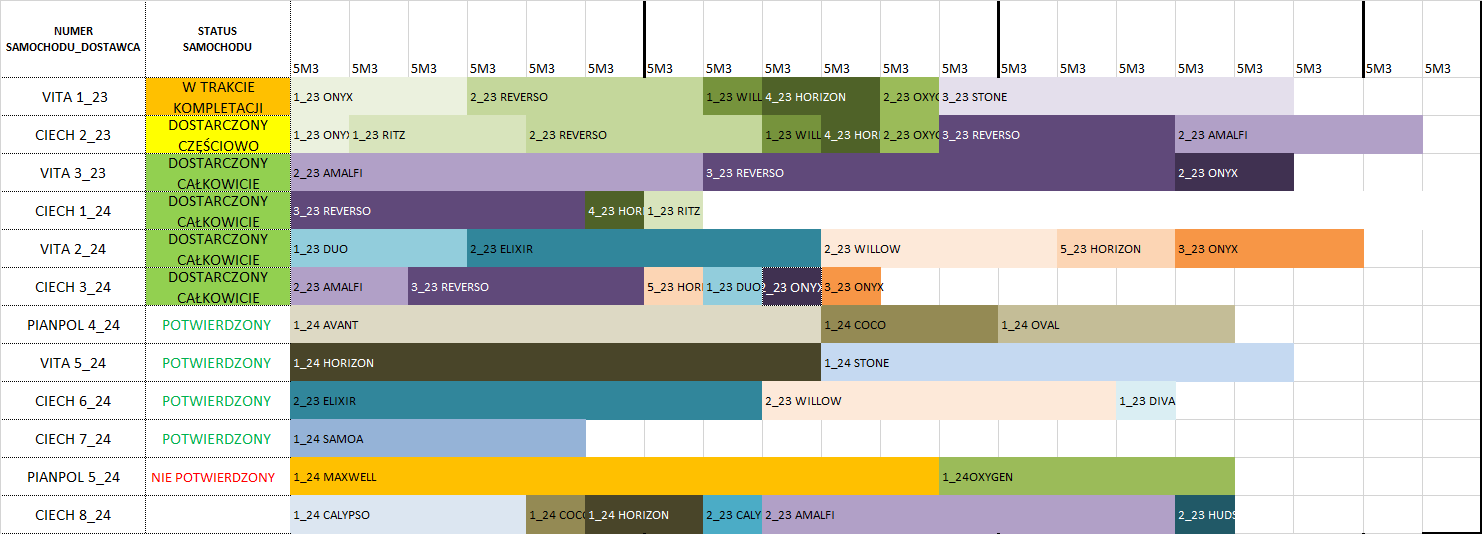

In [ ]:
nr_dostaw = zam_pianki_db[["LP", "MODEL", "NR_KOMPLETACJI", "OPIS", "DATA_DOSTARCZENIA_1", "DATA_DOSTARCZENIA_2", "nr_SAMOCHODU"]]
nr_dostaw["KOMPLETACJA"] = nr_dostaw.NR_KOMPLETACJI + " " + nr_dostaw.MODEL
nr_dostaw[["LP", "KOMPLETACJA", "OPIS", "DATA_DOSTARCZENIA_1", "DATA_DOSTARCZENIA_2", "nr_SAMOCHODU"]]

,LP,KOMPLETACJA,OPIS,DATA_DOSTARCZENIA_1,DATA_DOSTARCZENIA_2,nr_SAMOCHODU
0,1,1_24 CALYPSO,CALYPSO 1,None,None,CIECH 7_24
1,2,1_24 CALYPSO,CALYPSO 4,None,None,CIECH 7_24
2,3,1_24 CALYPSO,CALYPSO [LAD,None,None,CIECH 7_24
3,4,1_24 CALYPSO,CALYPSO [L2H,None,None,CIECH 7_24
4,5,1_24 CALYPSO,CALYPSO ][,None,None,CIECH 7_24
...,...,...,...,...,...,...
150,153,1_24 SPECTRA,SPECTRA 4z,None,None,CIECH 9_24
151,154,1_24 SPECTRA,SPECTRA [Lz,None,None,CIECH 9_24
152,155,1_24 SPECTRA,SPECTRA [L2Hz,None,None,CIECH 9_24
153,156,1_24 SPECTRA,SPECTRA ][,None,None,CIECH 9_24


In [ ]:
df = przyjecie_pz("ZAM1","AMALFI","1_23")
df#.LP.values

,LP,KOD,OPIS,ILE_ZAMOWIONE,POTW_DATA_DOS_1,ZNACZNIK_DOSTAWCY,STATUS_KOMPLETACJA,nr_PZ
35,38,16.135.69502.60,AMALFI RS] MEMORY,10,None,C,C,None
36,39,16.135.63072.60,AMALFI LA] MEMORY,15,None,C,C,None


In [ ]:
zam_pianki_db[["LP","OPIS", "NR_KOMPLETACJI", "ILE_ZAMOWIONE", "STATUS_KOMPLETACJA", "ZAM1", "ZAM2", "POTW_DATA_DOS_1", "DATA_DOSTARCZENIA_1", "nr_PZ", "nr_PW"]]

,LP,OPIS,NR_KOMPLETACJI,ILE_ZAMOWIONE,STATUS_KOMPLETACJA,ZAM1,ZAM2,POTW_DATA_DOS_1,DATA_DOSTARCZENIA_1,nr_PZ,nr_PW
0,1,CALYPSO 1,1_24,20,None,24/0007,None,29.01>30.01>31.01,None,None,None
1,2,CALYPSO 4,1_24,10,None,24/0007,None,29.01>30.01>31.01,None,None,None
2,3,CALYPSO [LAD,1_24,10,None,24/0007,None,29.01>30.01>31.01,None,None,None
3,4,CALYPSO [L2H,1_24,10,None,24/0007,None,29.01>30.01>31.01,None,None,None
4,5,CALYPSO ][,1_24,60,None,24/0007,None,29.01>30.01>31.01,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...
126,129,MAXWELL ][,1_24,100,None,23/0107,None,None,None,None,None
127,130,OXYGEN 3,1_24,40,None,23/0107,None,None,None,None,None
128,131,"OXYGEN 3,5",1_24,20,None,23/0107,None,None,None,None,None
129,132,OXYGEN [L2H,1_24,20,None,23/0107,None,None,None,None,None


In [ ]:
pz

,Numer,KARTA_LIMIT,Data,Obiekt docelowy,PZ,DOS
0,PZ+/60.1/24/0003,DOS/23/1486,2024-01-15,CIECH PIANKI SP Z O.O. /P,24/0003,23/1486
1,PZ+/60.1/24/0004,DOS/23/1416,2024-01-15,CIECH PIANKI SP Z O.O. /P,24/0004,23/1416
2,PZ+/60.1/24/0005,DOS/23/1416,2024-01-15,CIECH PIANKI SP Z O.O. /P,24/0005,23/1416
3,PZ+/60.1/24/0006,DOS/23/1406,2024-01-15,CIECH PIANKI SP Z O.O. /P,24/0006,23/1406
4,PZ+/60.1/24/0007,DOS/23/1406,2024-01-15,CIECH PIANKI SP Z O.O. /P,24/0007,23/1406
5,PZ+/60.1/24/0008,DOS/23/1488,2024-01-18,VITA POLYMERS POLAND SP. Z O.O. /P,24/0008,23/1488
6,PZ+/60.1/24/0009,DOS/23/1416,2024-01-22,CIECH PIANKI SP Z O.O. /P,24/0009,23/1416
7,PZ+/60.1/24/0010,DOS/23/1486,2024-01-22,CIECH PIANKI SP Z O.O. /P,24/0010,23/1486
8,PZ+/60.1/24/0012,DOS/23/1518,2024-01-24,VITA POLYMERS POLAND SP. Z O.O. /P,24/0012,23/1518
9,PZ+/60.1/24/0013,DOS/23/1486,2024-01-29,CIECH PIANKI SP Z O.O. /P,24/0013,23/1486


In [ ]:
zamowienia_niedostarczone = zamowienia_niedostarczone.fillna("")
zamowienia_niedostarczone

,LP,KOD,NR_KOMPLETACJI,OPIS,ILE_ZAMOWIONE,ZNACZNIK_DOSTAWCY,ZAM1,ZAM2,POTW_DATA_DOS_1,POTW_DATA_DOS_2,nr_SAMOCHODU
0,1,16.131.10000.60,1_24,CALYPSO 1,20,C,24/0007,,29.01>30.01>31.01,,CIECH 7_24
1,2,16.131.40000.60,1_24,CALYPSO 4,10,C,24/0007,,29.01>30.01>31.01,,CIECH 7_24
2,3,16.131.53083.60,1_24,CALYPSO [LAD,10,C,24/0007,,29.01>30.01>31.01,,CIECH 7_24
3,4,16.131.65004.60,1_24,CALYPSO [L2H,10,C,24/0007,,29.01>30.01>31.01,,CIECH 7_24
4,5,16.131.00001.60,1_24,CALYPSO ][,60,C,24/0007,,29.01>30.01>31.01,,CIECH 7_24
5,9,16.009.35003.60,1_24,"AVANT [3,5]",40,P,24/0035,,02/02,,PIANPOL 4_24
6,10,16.009.35000.60,1_24,"AVANT 3,5",15,P,24/0035,,02/02,,PIANPOL 4_24
7,11,16.009.25004.60,1_24,"AVANT 2,5][",25,P,24/0035,,02/02,,PIANPOL 4_24
8,12,16.009.66000.60,1_24,AVANT N,40,P,24/0035,,02/02,,PIANPOL 4_24
9,13,16.009.64004.60,1_24,AVANT LM][,25,P,24/0035,,02/02,,PIANPOL 4_24
